In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KernelDensity
import geopandas as gpd
from statsmodels.nonparametric.kde import KDEUnivariate

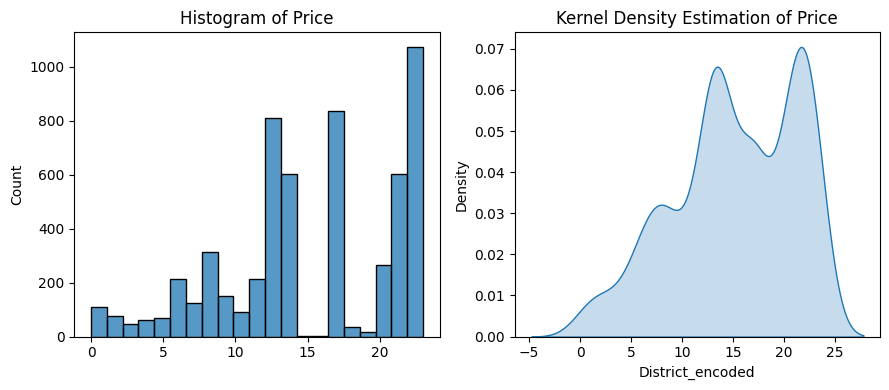

In [21]:

# Đọc dữ liệu từ file CSV
df = pd.read_csv('data.csv')

fig, axes = plt.subplots(1, 2, figsize=(9, 4))
# Histogram
sns.histplot(df['District_encoded'], ax=axes[0])
axes[0].set_title('Histogram of Price')
axes[0].set_xlabel('')
axes[0].set_ylabel('Count')

# KDE Plot
sns.kdeplot(df['District_encoded'], bw_adjust = 1.5, ax=axes[1],  fill=True, cmap='viridis')
axes[1].set_title('Kernel Density Estimation of Price')
axes[1].set_xlabel('District_encoded')
axes[1].set_ylabel('Density')

plt.tight_layout()
plt.show()